In [1]:
import pandas as pd
import numpy as np

In [2]:
resource=pd.read_csv('RAWDATA/test_set_1_2ap.csv')


In [3]:
resource.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 46 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   test_id                      80 non-null     int64  
 1   test_dur                     80 non-null     int64  
 2   loc_id                       80 non-null     object 
 3   protocol                     80 non-null     object 
 4   pkt_len                      80 non-null     int64  
 5   bss_id                       80 non-null     int64  
 6   ap_name                      80 non-null     object 
 7   ap_mac                       80 non-null     object 
 8   ap_id                        80 non-null     object 
 9   pd                           80 non-null     int64  
 10  ed                           80 non-null     int64  
 11  nav                          80 non-null     int64  
 12  eirp                         80 non-null     int64  
 13  ap_from_ap_0_sum_ant_r

In [4]:
columns=[0,1,2,4,6,7,8,12,19,20,22,23,25,26,28,29,31,32,40,42,43,44,45]
resource=resource.drop(resource.columns[columns],axis=1)

In [5]:
resource.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   protocol                    80 non-null     object 
 1   bss_id                      80 non-null     int64  
 2   pd                          80 non-null     int64  
 3   ed                          80 non-null     int64  
 4   nav                         80 non-null     int64  
 5   ap_from_ap_0_sum_ant_rssi   40 non-null     object 
 6   ap_from_ap_0_max_ant_rssi   40 non-null     object 
 7   ap_from_ap_0_mean_ant_rssi  40 non-null     object 
 8   ap_from_ap_1_sum_ant_rssi   40 non-null     object 
 9   ap_from_ap_1_max_ant_rssi   40 non-null     object 
 10  ap_from_ap_1_mean_ant_rssi  40 non-null     object 
 11  sta_to_ap_0_sum_ant_rssi    80 non-null     object 
 12  sta_to_ap_1_sum_ant_rssi    80 non-null     object 
 13  sta_from_ap_0_sum_ant_rssi  80 non-nu

In [6]:
for i in range(resource.shape[0]):
    if resource.iloc[i,list(resource.columns).index('bss_id')]==0:
        resource.iloc[i,list(resource.columns).index('ap_from_ap_0_sum_ant_rssi')]=resource.iloc[i,list(resource.columns).index('ap_from_ap_1_sum_ant_rssi')]
        resource.iloc[i,list(resource.columns).index('ap_from_ap_0_max_ant_rssi')]=resource.iloc[i,list(resource.columns).index('ap_from_ap_1_max_ant_rssi')]
        resource.iloc[i,list(resource.columns).index('ap_from_ap_0_mean_ant_rssi')]=resource.iloc[i,list(resource.columns).index('ap_from_ap_1_mean_ant_rssi')]
        resource.iloc[i,list(resource.columns).index('sta_from_sta_0_rssi')]=resource.iloc[i,list(resource.columns).index('sta_from_sta_1_rssi')]

In [7]:
resource=resource.drop(['ap_from_ap_1_sum_ant_rssi','ap_from_ap_1_max_ant_rssi',
                       'ap_from_ap_1_mean_ant_rssi','sta_from_sta_1_rssi'],axis=1)

In [8]:
resource.index=range(resource.shape[0])
# resource.to_excel('programe3_2ap.xlsx')

# 读入人工筛选的数据集

In [9]:
# 定义管理rssi中异常值数据，并创造出新特征值
def cal_pd(apmax,pd):
    apmax = eval(apmax)
    comparison_result = [1 if x >= pd else 0 for x in apmax]
    proportion_of_ones = sum(comparison_result) / len(apmax)
    return proportion_of_ones

def cal_ed(apmax,ed):
    apmax = eval(apmax)
    comparison_result = [1 if x >= ed else 0 for x in apmax]
    proportion_of_ones = sum(comparison_result) / len(apmax)
    return proportion_of_ones

def cal_nav(apmean,nav):
    apmean = eval(apmean)
    comparison_result = [1 if x >= nav else 0 for x in apmean]
    proportion_of_ones = sum(comparison_result) / len(apmean)
    return proportion_of_ones    


def cal_amsdu(seq_time, ppdu_dur, ampdu, per, throughput):
    # 计量单位：微秒 us
    # 一次发包成功总耗时为RTS+SIFS+CTS+SIFS+ppdu_dur
    # ppdu为一个数据帧的时长，即从RTS-CTS后发出数据帧到收到该帧的ACK
    success_dur = ppdu_dur
    # 一次发包失败总耗时为RTS+ACK_timeout = 85us
    fail_dur = 85.0

    # 假设成功发出x个ppdu包， 则有 per/(1-per) * x 个失败包
    # 总共耗时seq_time = per/(1-per) * x *fail_dur + x * success_dur
    x = seq_time / (success_dur + (per / (1-per) * fail_dur))
    """
    在802.11 WLAN中，最常见的PHY头部大小通常是160位（20字节），适用于802.11a、802.11g、802.11n、802.11ac和802.11ax等标准。这是因为这些标准大多数都基于OFDM（正交频分复用）调制，采用相同的PHY头部结构。
    对于802.11b（DSSS和CCK），虽然它的PHY头部是192位（24字节），但在现代无线网络中，802.11a/g/n/ac/ax的使用更为广泛，因此160位的PHY头部是最常见的。
    """
    pkg_len = 1500
    # 有效吞吐量（Mbps）为 x*effective_ppdu_len*8 / (60 * 1e6)
    # throughput = (x * effective_ppdu_len * 8.0) / (60 * 1e6)
    ppdu_len = throughput * 60 * 1e6 / (x*8)
    amsdu = ((ppdu_len-20) / ampdu - 40) / 1524
    return amsdu

In [10]:
resource['pro_pd'] = resource.apply(lambda row: cal_pd(row['ap_from_ap_0_max_ant_rssi'], row['pd']), axis=1)
resource['pro_ed'] = resource.apply(lambda row: cal_ed(row['ap_from_ap_0_max_ant_rssi'], row['ed']), axis=1)
resource['pro_nav'] = resource.apply(lambda row: cal_nav(row['ap_from_ap_0_mean_ant_rssi'], row['nav']), axis=1)

KeyError: 'throughput'

,protocol,bss_id,pd,ed,nav,ap_from_ap_0_sum_ant_rssi,ap_from_ap_0_max_ant_rssi,ap_from_ap_0_mean_ant_rssi,sta_to_ap_0_sum_ant_rssi,sta_to_ap_1_sum_ant_rssi,...,sta_from_sta_0_rssi,nss,mcs,per,num_ampdu,ppdu_dur,seq_time,pro_pd,pro_ed,pro_nav
0,tcp,1,-82,-62,-82,"[-82, -83, -83, -83, -83, -82, -83, -84, -87, ...","[-89, -91, -91, -90, -91, -89, -89, -91, -92, ...","[-91, -92, -92, -92, -92, -91, -92, -93, -96, ...","[-87, -87, -87, -87, -87, -67, -87, -82]","[-68, -66, -67, -66, -67, -67, -68, -67, -67, ...",...,NaN,2,6,0.05,NaN,NaN,47.2651,0.000000,0.0,0.000000
1,tcp,0,-82,-62,-82,"[-83, -84, -84, -85, -85, -84, -83, -85, -84, ...","[-90, -91, -90, -90, -92, -90, -91, -93, -92, ...","[-92, -93, -93, -94, -94, -93, -92, -94, -93, ...","[-83, -66, -65, -65, -66, -67, -66, -67, -67, ...","[-84, -85, -85, -85, -85, -85, -86, -85, -85, ...",...,NaN,2,7,0.04,NaN,NaN,48.3345,0.000000,0.0,0.000000
2,udp,1,-82,-62,-82,"[-82, -83, -83, -83, -83, -82, -83, -84, -87, ...","[-89, -91, -91, -90, -91, -89, -89, -91, -92, ...","[-91, -92, -92, -92, -92, -91, -92, -93, -96, ...","[-87, -87, -87, -87, -87, -67, -87, -82]","[-68, -66, -67, -66, -67, -67, -68, -67, -67, ...",...,NaN,2,7,0.03,NaN,NaN,49.8563,0.000000,0.0,0.000000
3,udp,0,-82,-62,-82,"[-83, -84, -84, -85, -85, -84, -83, -85, -84, ...","[-90, -91, -90, -90, -92, -90, -91, -93, -92, ...","[-92, -93, -93, -94, -94, -93, -92, -94, -93, ...","[-83, -66, -65, -65, -66, -67, -66, -67, -67, ...","[-84, -85, -85, -85, -85, -85, -86, -85, -85, ...",...,NaN,2,7,0.01,NaN,NaN,50.1373,0.000000,0.0,0.000000
4,tcp,1,-82,-62,-82,"[-82, -82, -85, -82, -81, -82, -81, -82, -82, ...","[-87, -88, -90, -89, -88, -90, -89, -89, -88, ...","[-91, -91, -94, -91, -90, -91, -90, -91, -91, ...","[-87, -87, -85, -87]","[-65, -66, -67, -66, -65, -66, -67, -60, -67, ...",...,NaN,2,7,0.04,NaN,NaN,47.2461,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,tcp,0,-82,-62,-82,"[-65, -67, -67, -68, -67, -68, -67, -68, -66, ...","[-73, -73, -74, -75, -73, -75, -74, -75, -72, ...","[-74, -76, -76, -77, -76, -77, -77, -77, -75, ...","[-65, -65, -64, -65, -66, -64, -66, -64, -66, ...","[-84, -81, -82, -83, -83, -83, -83, -83, -83, ...",...,NaN,2,9,0.16,NaN,NaN,23.6852,0.936170,0.0,0.936170
76,tcp,1,-82,-62,-82,"[-65, -63, -64, -64, -64, -65, -65, -63, -63, ...","[-70, -71, -71, -71, -69, -71, -71, -70, -69, ...","[-74, -72, -73, -73, -73, -74, -74, -72, -72, ...","[-69, -87, -66, -87, -67, -65, -66, -74, -87]","[-67, -67, -67, -67, -68, -67, -67, -64, -67, ...",...,NaN,2,11,0.02,NaN,NaN,26.9599,0.925000,0.0,0.948718
77,tcp,0,-82,-62,-82,"[-66, -67, -67, -66, -67, -66, -67, -66, -66, ...","[-73, -75, -73, -73, -73, -72, -73, -73, -71, ...","[-75, -76, -76, -75, -76, -75, -76, -75, -75, ...","[-65, -65, -62, -65, -63, -66, -65, -65, -65, ...","[-83, -82, -81, -82, -83, -84, -84, -69, -83, ...",...,NaN,2,11,0.22,NaN,NaN,23.4140,0.791667,0.0,0.925000
78,udp,1,-82,-62,-82,"[-65, -63, -64, -64, -64, -65, -65, -63, -63, ...","[-70, -71, -71, -71, -69, -71, -71, -70, -69, ...","[-74, -72, -73, -73, -73, -74, -74, -72, -72, ...","[-69, -87, -66, -87, -67, -65, -66, -74, -87]","[-67, -67, -67, -67, -68, -67, -67, -64, -67, ...",...,NaN,2,11,0.02,NaN,NaN,29.6329,0.925000,0.0,0.948718


In [11]:
resource.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   protocol                    80 non-null     object 
 1   bss_id                      80 non-null     int64  
 2   pd                          80 non-null     int64  
 3   ed                          80 non-null     int64  
 4   nav                         80 non-null     int64  
 5   ap_from_ap_0_sum_ant_rssi   80 non-null     object 
 6   ap_from_ap_0_max_ant_rssi   80 non-null     object 
 7   ap_from_ap_0_mean_ant_rssi  80 non-null     object 
 8   sta_to_ap_0_sum_ant_rssi    80 non-null     object 
 9   sta_to_ap_1_sum_ant_rssi    80 non-null     object 
 10  sta_from_ap_0_sum_ant_rssi  80 non-null     object 
 11  sta_from_ap_1_sum_ant_rssi  80 non-null     object 
 12  sta_from_sta_0_rssi         0 non-null      float64
 13  nss                         80 non-nu

num_amsdu std is 1.108420263672169
num_amsdu mean is 3.4488594574078184
pearson between num_amsdu and num_ampdu is 0.6327102984327106


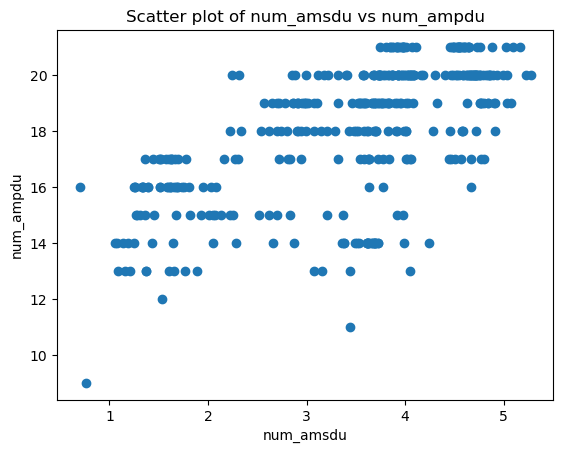

In [125]:
import matplotlib.pyplot as plt


data = resource
std = data['num_amsdu'].std()
mean = data['num_amsdu'].mean()
correlation = data['num_amsdu'].corr(data['num_ampdu'])
print(f'num_amsdu std is {std}')
print(f'num_amsdu mean is {mean}')
print(f'pearson between num_amsdu and num_ampdu is {correlation}')
#['num_amsdu'] = data['num_amsdu'].round()
import matplotlib.pyplot as plt

# 绘制散点图
plt.scatter(data['num_amsdu'], data['num_ampdu'])
plt.title('Scatter plot of num_amsdu vs num_ampdu')
plt.xlabel('num_amsdu')
plt.ylabel('num_ampdu')
plt.show()


In [14]:
# 删除无用的值

drop_columns=['pd','ed','ap_from_ap_0_mean_ant_rssi','ap_from_ap_0_max_ant_rssi']

# drop_columns=['pd','ed','ap_from_ap_0_mean_ant_rssi','ap_from_ap_0_max_ant_rssi'
#               ,'sta_to_ap_0_max_ant_rssi','sta_to_ap_0_mean_ant_rssi'
#               ,'sta_to_ap_1_max_ant_rssi','sta_to_ap_1_mean_ant_rssi'
#              ,'sta_from_ap_0_max_ant_rssi','sta_from_ap_0_mean_ant_rssi'
#              ,'sta_from_ap_1_max_ant_rssi','sta_from_ap_1_mean_ant_rssi']

resource=resource.drop(drop_columns,axis=1)

In [15]:
resource.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   protocol                    80 non-null     object 
 1   bss_id                      80 non-null     int64  
 2   nav                         80 non-null     int64  
 3   ap_from_ap_0_sum_ant_rssi   80 non-null     object 
 4   sta_to_ap_0_sum_ant_rssi    80 non-null     object 
 5   sta_to_ap_1_sum_ant_rssi    80 non-null     object 
 6   sta_from_ap_0_sum_ant_rssi  80 non-null     object 
 7   sta_from_ap_1_sum_ant_rssi  80 non-null     object 
 8   sta_from_sta_0_rssi         0 non-null      float64
 9   nss                         80 non-null     int64  
 10  mcs                         80 non-null     int64  
 11  per                         80 non-null     float64
 12  num_ampdu                   0 non-null      float64
 13  ppdu_dur                    0 non-nul

In [16]:
# 对RSSI求平均值处理
for i in range(3,8):
    resource.iloc[:,i]=resource.iloc[:,i].apply(lambda x: sum(eval(x))/len(eval(x)))

In [17]:
nss_mcs_dict=dict()
phy=[8.6,17.2,25.8,34.4,51.6,68.8,77.4,86.0,103.2,114.7,129.0,143.4,17.2,34.4,51.6,68.8,103.2,137.6,154.9,172.1,206.5,
    229.4,258.1,286.8]
num=0

for i in range(1,3):
    for j in range(0,12):
        nss_mcs_dict[(i,j)]=phy[num]
        num+=1

In [18]:
def get_phy(nss,mcs):
    return nss_mcs_dict[nss,mcs]

In [19]:
resource['phy_rate']=resource.apply(lambda row:get_phy(row['nss'],row['mcs']),axis=1)

In [20]:
resource=resource.drop(['nss','mcs'],axis=1)

In [21]:
resource.iloc[:,0]=resource.iloc[:,0].astype(str).map({'tcp':1,'udp':0})

In [22]:
resource.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   protocol                    80 non-null     object 
 1   bss_id                      80 non-null     int64  
 2   nav                         80 non-null     int64  
 3   ap_from_ap_0_sum_ant_rssi   80 non-null     object 
 4   sta_to_ap_0_sum_ant_rssi    80 non-null     object 
 5   sta_to_ap_1_sum_ant_rssi    80 non-null     object 
 6   sta_from_ap_0_sum_ant_rssi  80 non-null     object 
 7   sta_from_ap_1_sum_ant_rssi  80 non-null     object 
 8   sta_from_sta_0_rssi         0 non-null      float64
 9   per                         80 non-null     float64
 10  num_ampdu                   0 non-null      float64
 11  ppdu_dur                    0 non-null      float64
 12  seq_time                    80 non-null     float64
 13  pro_pd                      80 non-nu

In [23]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

df=resource.iloc[:,[14,15,16]]
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
df['cluster'] = kmeans.fit_predict(df)

# 查看每个簇的平均特征值
cluster_centers = pd.DataFrame(kmeans.cluster_centers_)
# columns=['pro_pd', 'pro_ed', 'pro_nav']

print(f"Cluster centers:\n{cluster_centers}")

# 查看每个簇的样本数量
print(df['cluster'].value_counts())
resource['state']=df['cluster']

# # 可视化聚类结果
# plt.scatter(df['pro_nav'], df['pro_pd'], c=df['cluster'], cmap='viridis', label='Cluster')
# plt.colorbar()
# plt.xlabel('pro_nav')
# plt.ylabel('pro_pd')
# plt.title('KMeans Clustering of WLAN Communication States')
# plt.show()
# 3D plot of the clustering results
# fig = plt.figure(figsize=(10, 7))
# ax = fig.add_subplot(111, projection='3d')

# # Plot the clusters in 3D
# scatter = ax.scatter(df['pro_nav'], df['pro_pd'], df['pro_ed'], c=df['cluster'], cmap='viridis')

# # Set labels and title
# ax.set_xlabel('pro_nav')
# ax.set_ylabel('pro_pd')
# ax.set_zlabel('pro_ed')
# ax.set_title('3D KMeans Clustering of WLAN Communication States')

# # Add a color bar
# plt.colorbar(scatter)

# plt.show()

D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
D:\Anaconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Cluster centers:
          0         1           2
0  0.001232  0.093311  220.403571
1  0.001603  0.919716  284.109375
2  0.001887  0.070259  171.240000
cluster
1    32
0    28
2    20
Name: count, dtype: int64


C:\Users\ShenFei\AppData\Local\Temp\ipykernel_22188\3999553685.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster'] = kmeans.fit_predict(df)


In [24]:
# 信干比采取dbm直接相减得到db
def func(x, y, state):
    if state == 0:
        return x + 100
    else:
        return x - y

    
# 创建一个新列来存储 SINR 计算的结果
sinr = []
df = resource
# 遍历 DataFrame 的每一行
for i in range(len(df)):
    if df.iloc[i, list(df.columns).index('bss_id')] == 1:  # ap1
        result = func(df.iloc[i, list(df.columns).index('sta_from_ap_1_sum_ant_rssi')], df.iloc[i, list(df.columns).index('sta_from_ap_0_sum_ant_rssi')],df.iloc[i, list(df.columns).index('state')])
    else:  # ap2
        result = func(df.iloc[i, list(df.columns).index('sta_from_ap_0_sum_ant_rssi')], df.iloc[i, list(df.columns).index('sta_from_ap_1_sum_ant_rssi')],df.iloc[i, list(df.columns).index('state')])
    sinr.append(result)

# 将计算结果添加为新列
df['sinr'] = sinr

# read from here

In [25]:
resource.to_excel('programe3_test_1_2ap_predict.xlsx')
# import numpy as np
# import pandas as pd
# resource = pd.read_excel('programe3_2ap_processed.xlsx')
# resource = resource.sample(frac=1).reset_index(drop=True)

# process

In [187]:
target=resource['throughput']
resource=resource.drop('throughput',axis=1)
resource=resource.drop('sta_from_sta_0_rssi',axis=1)
resource=resource.drop('bss_id',axis=1)
resource=resource.drop('num_ampdu',axis=1)
resource=resource.drop('ppdu_dur',axis=1)

In [207]:

resource.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 389 entries, 0 to 388
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   protocol                    389 non-null    int64  
 1   nav                         389 non-null    int64  
 2   ap_from_ap_0_sum_ant_rssi   389 non-null    float64
 3   sta_to_ap_0_sum_ant_rssi    389 non-null    float64
 4   sta_to_ap_1_sum_ant_rssi    389 non-null    float64
 5   sta_from_ap_0_sum_ant_rssi  389 non-null    float64
 6   sta_from_ap_1_sum_ant_rssi  389 non-null    float64
 7   per                         389 non-null    float64
 8   seq_time                    389 non-null    float64
 9   pro_pd                      389 non-null    float64
 10  pro_ed                      389 non-null    float64
 11  pro_nav                     389 non-null    float64
 12  phy_rate                    389 non-null    float64
 13  state                       389 non

In [204]:
from sklearn.ensemble import RandomForestRegressor

rfg=RandomForestRegressor(n_estimators=100,criterion='friedman_mse',min_samples_leaf=1,max_features='sqrt', max_depth = 20,random_state=0,oob_score=False)


# target_0_phy=pd.DataFrame(target_0_phy)

rfg=rfg.fit(resource,target)

# rfg0=RandomForestRegressor(n_estimators=100,criterion='friedman_mse',random_state=0,oob_score=False)
# rfg0=rfg0.fit(resource,target_0.to_numpy())
from sklearn.model_selection import cross_val_score

res=cross_val_score(rfg,resource,target,cv=10)

In [205]:
res.mean()

0.9645740214061803

In [206]:
res

array([0.98174756, 0.96517943, 0.96197336, 0.96635765, 0.89696014,
       0.9692583 , 0.97443453, 0.97289633, 0.97986025, 0.97707267])

In [192]:
rfg.feature_importances_

array([8.49952890e-03, 5.56821507e-04, 2.99802118e-03, 3.54211240e-03,
       3.17879362e-03, 2.67604264e-03, 1.41655807e-03, 6.41949338e-01,
       2.42068417e-01, 2.44999665e-03, 2.54208718e-04, 3.72005282e-03,
       7.93924425e-02, 1.31686572e-03, 5.98080000e-03])

In [193]:
resource_columns = resource.columns
resource_columns[np.argsort(rfg.feature_importances_)]


Index(['pro_ed', 'nav', 'state', 'sta_from_ap_1_sum_ant_rssi', 'pro_pd',
       'sta_from_ap_0_sum_ant_rssi', 'ap_from_ap_0_sum_ant_rssi',
       'sta_to_ap_1_sum_ant_rssi', 'sta_to_ap_0_sum_ant_rssi', 'pro_nav',
       'sinr', 'protocol', 'phy_rate', 'seq_time', 'per'],
      dtype='object')

In [ ]:
for i in range(resource.shape[0]):
    if resource.iloc[i,list(resource.columns).index('bss_id')]==2:
        continue
    else: 
        if resource.iloc[i,list(resource.columns).index('bss_id')]==0:
            resource.iloc[i,list(resource.columns).index('ap_from_ap_0_sum_ant_rssi')]=resource.iloc[i,list(resource.columns).index('ap_from_ap_1_sum_ant_rssi')]
            resource.iloc[i,list(resource.columns).index('ap_from_ap_0_max_ant_rssi')]=resource.iloc[i,list(resource.columns).index('ap_from_ap_1_max_ant_rssi')]
            resource.iloc[i,list(resource.columns).index('ap_from_ap_0_mean_ant_rssi')]=resource.iloc[i,list(resource.columns).index('ap_from_ap_1_mean_ant_rssi')]
            resource.iloc[i,list(resource.columns).index('sta_from_sta_0_rssi')]=resource.iloc[i,list(resource.columns).index('sta_from_sta_1_rssi')]
        resource.iloc[i,list(resource.columns).index('ap_from_ap_1_sum_ant_rssi')]=resource.iloc[i,list(resource.columns).index('ap_from_ap_2_sum_ant_rssi')]
        resource.iloc[i,list(resource.columns).index('ap_from_ap_1_max_ant_rssi')]=resource.iloc[i,list(resource.columns).index('ap_from_ap_2_max_ant_rssi')]
        resource.iloc[i,list(resource.columns).index('ap_from_ap_1_mean_ant_rssi')]=resource.iloc[i,list(resource.columns).index('ap_from_ap_2_mean_ant_rssi')]
        resource.iloc[i,list(resource.columns).index('sta_from_sta_1_rssi')]=resource.iloc[i,list(resource.columns).index('sta_from_sta_2_rssi')]

# predict